In [1]:
%pylab inline
import GPy
import GPyOpt
import numpy as np
import matplotlib.pyplot as plt
from GPyOpt.util.pareto import ParetoFront
from GPyOpt.experiment_design import initial_design
from GPyOpt.acquisitions.HvEI import AcquisitionHvEI
from GPyOpt.methods import ModularBayesianMultiobjectiveOptimization

Populating the interactive namespace from numpy and matplotlib


In [2]:
def ChankongHaimes(x,y):
    f1 = 2 + (x-2.)**2 + (y-1.0)**2
    f2 = 9.*x - (y-1.)**2
    return np.array([f1,f2])

def constraints(x,y):
    c1 = 225 - x**2 - y**2 
    c2 = -(x-3*y+10)
    return np.array([c1,c2])

In [3]:
np.set_printoptions(precision=6)

objective = None 

space =[{'name': 'var_1', 'type': 'continuous', 'domain': (-20.0,20.0)},
        {'name': 'var_2', 'type': 'continuous', 'domain': (-20.0,20.0)}]
space = GPyOpt.Design_space(space = space)

kernel   = None 
kernel_c = None

model_f1 = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)
model_f2 = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)
model_f  = [model_f1,model_f2]

model_c1 = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)
model_c2 = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)
model_c  = [model_c1,model_c2]

aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)

num_init = 80
typ_init = 'latin'
X_init = initial_design(typ_init,space,num_init)

Y_init = np.zeros((X_init.shape[0],2))
C_init = np.zeros((X_init.shape[0],2))

for i in range(num_init):
    Y_init[i,:] = ChankongHaimes(X_init[i,0],X_init[i,1])
    C_init[i,:] = constraints(X_init[i,0],X_init[i,1])

np.set_printoptions(precision=4)
print(np.hstack((X_init,Y_init,C_init)))

[[ 3.7500e+00 -9.2500e+00  1.1012e+02 -7.1312e+01  1.2538e+02 -4.1500e+01]
 [-6.2500e+00 -4.2500e+00  9.7625e+01 -8.3812e+01  1.6788e+02 -1.6500e+01]
 [ 1.8250e+01 -1.4750e+01  5.1412e+02 -8.3812e+01 -3.2562e+02 -7.2500e+01]
 [-1.5250e+01 -1.5250e+01  5.6362e+02 -4.0131e+02 -2.4012e+02 -4.0500e+01]
 [ 1.1750e+01 -7.7500e+00  1.7363e+02  2.9188e+01  2.6875e+01 -4.5000e+01]
 [ 1.4250e+01  7.2500e+00  1.9112e+02  8.9188e+01 -3.0625e+01 -2.5000e+00]
 [ 1.1250e+01 -6.7500e+00  1.4762e+02  4.1188e+01  5.2875e+01 -4.1500e+01]
 [ 1.3250e+01 -1.2500e+00  1.3362e+02  1.1419e+02  4.7875e+01 -2.7000e+01]
 [ 1.7750e+01  1.6250e+01  4.8262e+02 -7.2812e+01 -3.5412e+02  2.1000e+01]
 [ 9.2500e+00  1.7500e+00  5.5125e+01  8.2688e+01  1.3637e+02 -1.4000e+01]
 [-1.7750e+01 -8.7500e+00  4.8712e+02 -2.5481e+02 -1.6662e+02 -1.8500e+01]
 [-1.8250e+01  9.7500e+00  4.8862e+02 -2.4081e+02 -2.0312e+02  3.7500e+01]
 [ 4.7500e+00  1.7250e+01  2.7362e+02 -2.2131e+02 -9.5125e+01  3.7000e+01]
 [-1.6250e+01 -3.2500e+00

In [4]:
iter_count = 180-num_init
current_iter = 0
X_step = X_init
Y_step = Y_init
C_step = C_init 

while current_iter < iter_count:
    C_clip = np.copy(C_step)
    C_clip[C_clip > 0] = 0.0
    C_clip = np.sum(C_clip**2,axis=1)
    
    Pareto = ParetoFront(Y_step[C_clip==0.0,:])
    
    print(Pareto.shape)
    
    acquisition = AcquisitionHvEI(model_f,space,optimizer=aquisition_optimizer, jitter = 1e-3,
                                  model_c=model_c,jitter_c = np.array([0.0,0.0]),P=Pareto,r=np.array([250,0]))
    
    # --- CHOOSE a collection method
    evaluator = GPyOpt.core.evaluators.Sequential(acquisition)
    
    bo_step = ModularBayesianMultiobjectiveOptimization(model_f, space, objective, acquisition, evaluator, 
                                                        X_init = X_step, Y_init = Y_step, C_init = C_step, 
                                                        model_c = model_c, normalize_Y = False)
    
    x_next = bo_step.suggest_next_locations()
    y_next = ChankongHaimes(x_next[0][0],x_next[0][1])
    c_next = constraints(x_next[0][0],x_next[0][1])
    print("Current iteration - ",current_iter," : ",np.array([x_next[0][0],x_next[0][1],y_next[0],y_next[1],c_next[0],c_next[1]]))
    
    X_step = np.vstack((X_step, x_next))
    Y_step = np.vstack((Y_step, y_next))
    C_step = np.vstack((C_step, c_next))
    
    current_iter += 1

(4, 2)
Current iteration -  0  :  [ -7.8232   4.0137 107.5782 -79.4915 147.6872   9.8644]
(4, 2)
Current iteration -  1  :  [ -7.8413   4.009  107.9054 -79.6257 147.442    9.8682]
(4, 2)
Current iteration -  2  :  [ -7.9135   4.0082 109.3261 -80.2705 146.3114   9.9381]
(4, 2)
Current iteration -  3  :  [ -7.8816   4.0115 108.7147 -80.0033 146.7886   9.9161]
(4, 2)
Current iteration -  4  :  [ -7.8796   4.0059 108.6411 -79.9515 146.8652   9.8973]
(4, 2)
Current iteration -  5  :  [ -7.8974   4.0054 108.9919 -80.1095 146.587    9.9137]
(4, 2)
Current iteration -  6  :  [ -7.876    4.0072 108.578  -79.9271 146.9114   9.8977]
(4, 2)
Current iteration -  7  :  [ -7.8727   4.0016 108.4794 -79.8637 147.0081   9.8775]
(4, 2)
Current iteration -  8  :  [ -7.8794   4.0037 108.6253 -79.9372 146.8849   9.8906]
(4, 2)
Current iteration -  9  :  [ -7.8756   3.9993 108.5223 -79.8758 146.9813   9.8734]
(4, 2)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



KeyboardInterrupt caught, calling on_optimization_end() to round things up
Traceback (most recent call last):
  File "C:\Users\jhelsas\AppData\Local\Continuum\anaconda3\envs\cBO\lib\site-packages\IPython\core\interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-b1c805f58834>", line 26, in <module>
    x_next = bo_step.suggest_next_locations()
  File "d:\users\jhelsas\projetos\gpyopt\GPyOpt\core\bo_biobj.py", line 76, in suggest_next_locations
    self._update_model(self.normalization_type)
  File "d:\users\jhelsas\projetos\gpyopt\GPyOpt\core\bo_biobj.py", line 283, in _update_model
    mdl_c.updateModel(X_inmodel, C_inmodel[:,i:(i+1)], None, None) # Updating the constraint model
  File "d:\users\jhelsas\projetos\gpyopt\GPyOpt\models\gpmodel.py", line 91, in updateModel
    self.model.optimize_restarts(num_restarts=self.optimize_restarts, optimizer=self.optimizer, max_iters = self.max_iters, verbose=self.verbose)
  F

KeyboardInterrupt: 

In [2]:
content = np.load('Chankong-Haimes.npz')
X_step = content['X_step']
Y_step = content['Y_step']
C_step = content['C_step']

In [3]:
import matplotlib.pyplot as plt

In [4]:
C_clip = np.copy(C_step)
C_clip[C_clip > 0] = 0.0
C_clip = np.sum(C_clip**2,axis=1)

Pareto = ParetoFront(Y_step[C_clip==0.0,:])

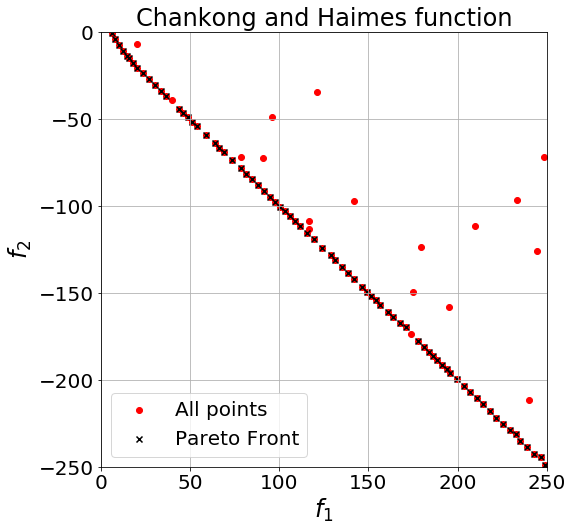

In [8]:
fig = plt.figure(figsize=(8,8))
plt.scatter(Y_step[:,0],Y_step[:,1],c='r',label='All points')
plt.scatter(Pareto[:,0],Pareto[:,1],c='k',marker='x',label='Pareto Front')
plt.legend(loc='lower left',fontsize=20)
plt.xlim((0,250))
plt.ylim((-250,0))

plt.grid()

plt.title("Chankong and Haimes function",fontsize=24)
plt.xlabel(r'$f_1$',fontsize=24)
plt.ylabel(r'$f_2$',fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig("Chankong-Haimes.png",bbox_inches='tight')
plt.show()

In [6]:
np.savez('Chankong-Haimes.npz',X_step=X_step,Y_step=Y_step,C_step=C_step)